In [132]:
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from common import Fonts, Images

In [92]:
# Read in score progression data
f = open("2022_score_progressions.json")
data = json.load(f)
data

{'LA': [[[0, [0, 0]], [3, [1, 0]], [13, [2, 0]], [51, [2, 1]]],
  [[0, [0, 0]], [3, [0, 1]]],
  [[0, [0, 0]], [42, [1, 0]]],
  [[0, [0, 0]], [70, [1, 0]]],
  [[0, [0, 0]], [57, [0, 1]]],
  [[0, [0, 0]], [15, [0, 1]], [18, [0, 2]], [68, [0, 3]]],
  [[0, [0, 0]]],
  [[0, [0, 0]],
   [29, [0, 1]],
   [36, [1, 1]],
   [47, [2, 1]],
   [65, [2, 2]],
   [90, [3, 2]]],
  [[0, [0, 0]], [31, [0, 1]]],
  [[0, [0, 0]], [2, [1, 0]], [90, [1, 1]]],
  [[0, [0, 0]], [9, [1, 0]], [59, [1, 1]], [81, [2, 1]]],
  [[0, [0, 0]],
   [9, [1, 0]],
   [28, [2, 0]],
   [54, [2, 1]],
   [64, [2, 2]],
   [89, [2, 3]]],
  [[0, [0, 0]], [40, [1, 0]], [64, [1, 1]], [72, [2, 1]], [90, [2, 2]]],
  [[0, [0, 0]], [48, [1, 0]]],
  [[0, [0, 0]], [78, [1, 0]], [82, [1, 1]]],
  [[0, [0, 0]], [16, [1, 0]], [25, [2, 0]], [31, [3, 0]], [52, [3, 1]]],
  [[0, [0, 0]], [43, [0, 1]], [49, [1, 1]]],
  [[0, [0, 0]], [54, [0, 1]]],
  [[0, [0, 0]], [30, [0, 1]]],
  [[0, [0, 0]], [39, [1, 0]], [51, [2, 0]], [88, [2, 1]]],
  [[0, [0, 0]

In [93]:
# Grab the data for a specific team
team = "RGN"
progression = data[team]

In [94]:
# Sort progressions by end of game goal differential
def compare(p):
    if len(p) == 1:
        return 0
    else:
        return p[1][1][1] - p[1][1][0]
progression = sorted(progression, key=compare)  

In [115]:
# Pre-calculate the number of paths going through each node. In 
# this example the first index is the index of the goal and the
# second index is the goal differential.
counts = defaultdict(lambda: defaultdict(int))
for game in progression:
    i = 0
    for minute, goal in game:
        counts[i][goal[1] - goal[0]] += 1
        i+=1
        
counts

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {0: 22}),
             1: defaultdict(int, {-1: 11, 1: 9}),
             2: defaultdict(int, {-2: 4, 0: 9, 2: 1}),
             3: defaultdict(int, {1: 5, -3: 2, -1: 3}),
             4: defaultdict(int, {-2: 1, 0: 4}),
             5: defaultdict(int, {-3: 1, -1: 1})})

<Figure size 720x864 with 0 Axes>

<Figure size 12000x14400 with 0 Axes>

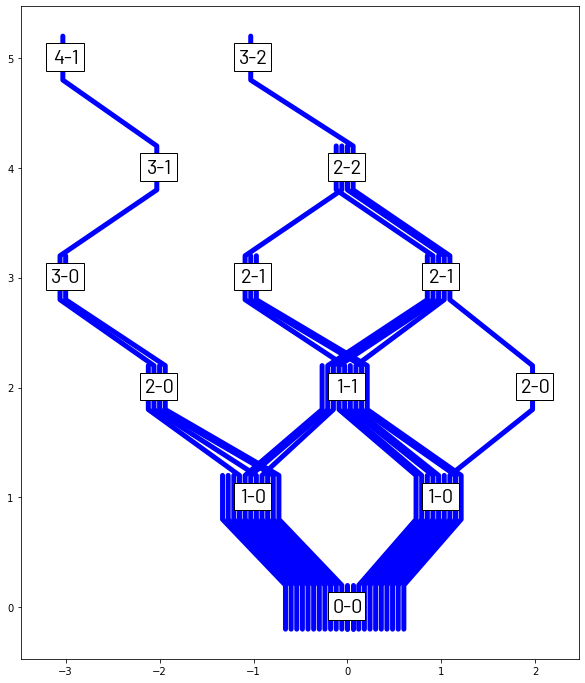

In [135]:
# General
plt.clf()
plt.rcParams["figure.figsize"] = (10, 12)
plt.figure(dpi=1200, facecolor="white")
fig, ax = plt.subplots()
fig.patch.set_facecolor("white")

# Plot lines
drawn = defaultdict(lambda: defaultdict(int))

for i, game in enumerate(progression):
    x = []
    y = []
    for minute, goal in game:
        new_x = goal[1] - goal[0]
        new_y = int(y[-1] + 0.8) if len(y) > 0 else 0

        lines_at_node = counts.get(new_y).get(new_x)
        lines_drawn = drawn[new_y][new_x]

        # Adjust to spread out lines at each node
        adjusted_x = new_x + (lines_drawn - lines_at_node / 2) * 0.06

        # Add two points so the line is straight when going through the node
        x.append(adjusted_x)
        y.append(new_y - 0.2)
        x.append(adjusted_x)
        y.append(new_y + 0.2)

        drawn[new_y][new_x] += 1

    # For 0-0 games add a second variable with a tiny line to make sure it
    # gets drawn.
    if len(x) == 1:
        x = [x[0], x[0] + 0.0001]
        y = [y[0], y[0] + 0.0001]

    # TODO(agale): Add color gradient
    plt.plot(x, y, linewidth=5, solid_capstyle="round", color="blue")

# Add score labels

# Constants for rendering labels
w = 0.4
h = 0.25
x_off = -0.01
y_off = 0.01

# Format the score based on the x and y coordinate
def format_scores(x, y):
    if x == 0:
        return str(int(y / 2)) + "-" + str(int(y / 2))
    elif x < 0:
        shared = y + x
        return str(int(shared / 2 - x)) + "-" + str(int(shared / 2))
    else:
        shared = y - x
        return str(int(shared / 2 + x)) + "-" + str(int(shared / 2))


# Iterate over all nodes that have lines through them to add labels
for y in counts.keys():
    for x in counts[y].keys():
        ax.text(
            x,
            y,
            format_scores(x, y),
            color="black",
            fontsize=20,
            fontproperties=Fonts.BARLOW,
            fontweight="bold",
            va="center",
            ha="center",
        )

        rect = patches.Rectangle(
            (x - w / 2 + x_off, y - h / 2 + y_off),
            w,
            h,
            linewidth=1,
            edgecolor="black",
            facecolor="white",
            zorder=2,
        )
        # add rectangle to plot
        ax.add_patch(rect)

# Save image
plt.savefig("score_progression_v7.png", bbox_inches="tight", pad_inches=0.5)

In [109]:
counts.get(7)